In [46]:
import torch 
import torch.nn as nn 
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision

import matplotlib.pyplot as plt
import numpy as np 

In [67]:
device = None 
if torch.cuda.is_available(): 
    device = "cuda"
else: 
    device = "cpu"

In [9]:
transform = {
    "train" : transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ]), 
    "val" : transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.5,), (0.5,))
    ])
}

In [17]:
batch_size = 4

In [12]:
train_ds = datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform["train"])


val_ds = datasets.CIFAR100(root='./data', train=False,
                                        download=True, transform=transform["val"])


Extracting ./data\cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [15]:
train_size = train_ds.data.shape
val_size = val_ds.data.shape

print("train :", train_size)
print("val :", val_size)

train : (50000, 32, 32, 3)
val : (10000, 32, 32, 3)


In [18]:
train_ds = torch.utils.data.DataLoader(
    train_ds, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=4
)

val_ds = torch.utils.data.DataLoader(
    val_ds, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=4
)


In [24]:
data = iter(train_ds)
inputs, labels = data.next()


In [54]:
def plot_image(inp, title=None):
    if title is not None: 
        plt.title(f"label : {title}") 
    
    inp = inp.numpy()
    inp = np.transpose(inp, (1, 2, 0))
    inp = inp * 0.5 + 0.5
    plt.imshow(inp)
    return plt.show()


In [57]:
grid = torchvision.utils.make_grid(inputs)

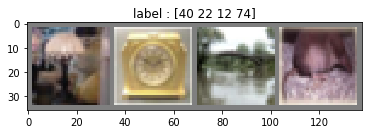

In [62]:
plot_image(grid, labels.numpy())

In [63]:
import torch.nn.functional as F


In [188]:
class ResidualBlock(nn.Module): 
    
    def __init__(self, output_filter,prev_filter, downsample=False): 
        super(ResidualBlock, self).__init__()
        self.downsample = downsample
        self.prev_filter = prev_filter
        self.conv_down = None
        stride = None
        if downsample: 
            stride = 2 
            self.conv_down = torch.nn.Conv2d(prev_filter, output_filter, 1, stride=stride)
        else: 
            stride = 1
        
        
        self.output_filter = output_filter
        self.conv1 = torch.nn.Conv2d(prev_filter, output_filter, 3, padding=1)
        self.conv2 = torch.nn.Conv2d(output_filter, output_filter, 3, stride=stride, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(output_filter)
        self.bn2 = torch.nn.BatchNorm2d(output_filter)
        
        
    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        if self.downsample: 
            inputs = self.conv_down(inputs)
            intputs = self.bn1(inputs)    
        print("x:", x.shape)
        print("inp:", inputs.shape)
        x = F.relu(inputs + x)
        return x

In [189]:
from torchsummary import summary

block = ResidualBlock(56, 56, downsample=True)
block.to(device)
summary(block, batch_size=batch_size, input_size=(56, 32, 32))

x: torch.Size([2, 56, 16, 16])
inp: torch.Size([2, 56, 16, 16])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [4, 56, 32, 32]          28,280
       BatchNorm2d-2            [4, 56, 32, 32]             112
            Conv2d-3            [4, 56, 16, 16]          28,280
       BatchNorm2d-4            [4, 56, 16, 16]             112
            Conv2d-5            [4, 56, 16, 16]           3,192
       BatchNorm2d-6            [4, 56, 16, 16]             112
Total params: 60,088
Trainable params: 60,088
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.88
Forward/backward pass size (MB): 5.25
Params size (MB): 0.23
Estimated Total Size (MB): 6.35
----------------------------------------------------------------


In [190]:
class ResidualLayer(nn.Module): 
    
    def __init__(self, filter_list, prev_filter, stride=1): 
        super(ResidualLayer, self).__init__()
        self.prev_filter = prev_filter
        self.filter_list = filter_list
        self.stride = stride
        self.layers = self.build_layer()
            
    def build_layer(self): 
        layers = []
        for i in range(len(self.filter_list)): 
            if i == 0: 
                layers.append(ResidualBlock(self.filter_list[i], self.prev_filter))
                prev_filter = self.filter_list[i]
                
            elif self.stride == 2 and i == len(self.filter_list) - 1: 
                layers.append(ResidualBlock(self.filter_list[i], self.prev_filter, downsample=True)) 
            else: 
                layers.append(ResidualBlock(self.filter_list[i], self.prev_filter)) 
                                   
        return nn.Sequential(*layers)
                                   
    def forward(self, x): 
        for layer in self.layers: 
            x = layer(x)
        print(x.shape)
        return x

In [191]:
layer = ResidualLayer([64, 64], 64, stride=2)
layer.to(device)
summary(layer, batch_size=batch_size, input_size=(64, 32, 32))

x: torch.Size([2, 64, 32, 32])
inp: torch.Size([2, 64, 32, 32])
x: torch.Size([2, 64, 16, 16])
inp: torch.Size([2, 64, 16, 16])
torch.Size([2, 64, 16, 16])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [4, 64, 32, 32]          36,928
       BatchNorm2d-2            [4, 64, 32, 32]             128
            Conv2d-3            [4, 64, 32, 32]          36,928
       BatchNorm2d-4            [4, 64, 32, 32]             128
     ResidualBlock-5            [4, 64, 32, 32]               0
            Conv2d-6            [4, 64, 32, 32]          36,928
       BatchNorm2d-7            [4, 64, 32, 32]             128
            Conv2d-8            [4, 64, 16, 16]          36,928
       BatchNorm2d-9            [4, 64, 16, 16]             128
           Conv2d-10            [4, 64, 16, 16]           4,160
      BatchNorm2d-11            [4, 64, 16, 16]             128
    Residua

In [194]:
class Resnet34(nn.Module): 
    
    def __init__(self): 
        super(Resnet34, self).__init__() 
        self.conv1 = torch.nn.Conv2d(3, 64, 7, stride=2)
        self.pool1 = torch.nn.MaxPool2d(2, stride=2)
        self.bn1 = torch.nn.BatchNorm2d(64)
        
        self.block1 = ResidualLayer([64, 64], 64)
        self.block2 = ResidualLayer([64, 64], 64, stride=2)
        self.block3 = ResidualLayer([128, 128], 64)
        self.block4 = ResidualLayer([128, 128], 128)
        self.block5 = ResidualLayer([256, 256], 128, stride=2)
        self.block6 = ResidualLayer([256, 256], 256)
        self.block7 = ResidualLayer([256, 256], 256, stride=2)
        
    def forward(self, x): 
        
        x = F.relu(self.bn1(self.conv1(x)))
        
        x = self.pool1(x)
        
        x = self.block1(x)
        x = self.block2(x)
        print("block2 shape", 
              x.shape)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = self.block7(x)
        
        return x

In [195]:
resnet = Resnet34()
resnet.to(device)

summary(resnet, batch_size=batch_size, input_size=(3, 32, 32))

x: torch.Size([2, 64, 6, 6])
inp: torch.Size([2, 64, 6, 6])
x: torch.Size([2, 64, 6, 6])
inp: torch.Size([2, 64, 6, 6])
torch.Size([2, 64, 6, 6])
x: torch.Size([2, 64, 6, 6])
inp: torch.Size([2, 64, 6, 6])
x: torch.Size([2, 64, 3, 3])
inp: torch.Size([2, 64, 3, 3])
torch.Size([2, 64, 3, 3])
block2 shape torch.Size([2, 64, 3, 3])
x: torch.Size([2, 128, 3, 3])
inp: torch.Size([2, 64, 3, 3])


RuntimeError: The size of tensor a (64) must match the size of tensor b (128) at non-singleton dimension 1